### Dataset Extraction from Google Drive to JupiterHub

Notebook contains code for downloading dataset from Google Drive to JupiterHub

In [ ]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile
import importlib.util
import sys
from pathlib import Path

In [ ]:
pip install pydrive

In [ ]:
pip install pydrive2

In [ ]:
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive

gauth = GoogleAuth()
gauth.LoadClientConfigFile("./extraction_credentials/credentials.json")

gauth.LoadCredentialsFile("./extraction_credentials/token.json")

if not gauth.credentials or gauth.access_token_expired:
    gauth.CommandLineAuth()
    gauth.SaveCredentialsFile("./extraction_credentials/token.json")
else:
    gauth.Authorize()

drive = GoogleDrive(gauth)

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?client_id=1039694969703-1hrvn3fon16ar5bk3qpitbad3cl2c110.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=online&response_type=code



Enter verification code:  4/1AUJR-x406xLc803Za6DQqLoXMRsobnl5TPyRC1gKEypn0Mp3Fmj4dMDUU5k


Authentication successful.


### Extracting Data

In [ ]:
folder_id = '1SzgHGweRe0hdLWIbaxbGO7jBmg1JD-AS'

zip_file_list = drive.ListFile({'q': f"'{folder_id}' in parents and trashed=false"}).GetList()

local_zip_dir = "./Boris full zip"
os.makedirs(local_zip_dir, exist_ok=True)

for file in zip_file_list:
    if file['title'].endswith('.zip'):
        local_path = os.path.join(local_zip_dir, file['title'])
        if not os.path.exists(local_path): 
            print(f"Downloading {file['title']}...")
            file.GetContentFile(local_path)
        else:
            print(f"Already downloaded: {file['title']}")

In [ ]:
extract_root = "./Data_Boris_full"
os.makedirs(extract_root, exist_ok=True)

for zip_file in os.listdir(local_zip_dir):
    if zip_file.endswith('.zip'):
        zip_path = os.path.join(local_zip_dir, zip_file)
        print(f"Extracting {zip_file}...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_root)

Extracting before_data_BorisFlood2024_raw.zip...
Extracting data_BorisFlood2024_raw.zip...


In [ ]:
def load_module(name, path):
    path = Path(path).resolve()
    spec = importlib.util.spec_from_file_location(name, path)
    module = importlib.util.module_from_spec(spec)
    sys.modules[name] = module
    spec.loader.exec_module(module)
    return module

In [ ]:
masks_creation = load_module("masks_creation", "scripts/data_preparation/masks_creation.py")
visualize_tiled_image_and_mask = masks_creation.visualize_tiled_image_and_mask

### Preparing dataset & Oversampling

### Oversampling

In [8]:
preprocessing = load_module("preprocessing", "scripts/data_model/preprocessing.py")

run_preprocessing = preprocessing.run_preprocessing
get_sample_water_ratios = preprocessing.get_sample_water_ratios
bin_samples_by_water_ratio = preprocessing.bin_samples_by_water_ratio
sample_from_bins = preprocessing.sample_from_bins
split_dataset = preprocessing.split_dataset
gather_all_years = preprocessing.gather_all_years
save_water_ratios_to_json = preprocessing.save_water_ratios_to_json
count_bins = preprocessing.count_bins


data_dir = "./Data"

all_pairs = gather_all_years(data_dir)
print(f"Found {len(all_pairs)} total samples.")

Processing year: before_data_GermanyFlood2021_raw
Processing year: data_Q3_2022_raw
Processing year: data_Q4_2024_raw
Processing year: waterbodies_data_Q1_2023_raw
Processing year: data_Q1_2022_raw
Processing year: data_GermanyFlood2021_raw
Processing year: data_GermanySouthFlood2024_raw
Processing year: waterbodies_data_Q1_2022_raw
Processing year: waterbodies_data_Q1_2024_raw
Processing year: waterbodies_data_Q4_2023_raw
Processing year: waterbodies_data_Q2_2022_raw
Processing year: data_Q4_2022_raw
Processing year: data_Q1_2024_raw
Processing year: data_Q3_2024_raw
Processing year: data_Q1_2023_raw
Processing year: waterbodies_data_Q4_2022_raw
Processing year: waterbodies_data_Q3_2024_raw
Processing year: waterbodies_data_Q2_2023_raw
Processing year: data_Q4_2023_raw
Processing year: data_Q2_2023_raw
Processing year: waterbodies_data_Q2_2024_raw
Processing year: data_Q2_2022_raw
Processing year: data_Q2_2024_raw
Processing year: Split
Processing year: before_data_GermanySouthFlood20

In [51]:
#save pixel % for each pair
ratios_with_pairs = get_sample_water_ratios(all_pairs)
save_water_ratios_to_json(ratios_with_pairs, "./Data/Split/water_ratios.json")

Scanning masks for water:   8%|▊         | 3739/47772 [00:03<00:37, 1163.98it/s]/opt/conda/lib/python3.11/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Scanning masks for water: 100%|██████████| 47772/47772 [00:45<00:00, 1059.52it/s]


In [49]:
binned = bin_samples_by_water_ratio(ratios_with_pairs)

In [ ]:
print("Water ratio distribution:")
for bin_name, count in bin_counts.items():
    print(f"{bin_name}: {count} samples")

Water ratio distribution:
0: 36562 samples
0-10: 8907 samples
10-20: 37477 samples
20-30: 402 samples
30+: 986 samples


In [ ]:
desired_sizes = {
    "0": 0,
    "0-10": 5724,
    "10-20": 8500,
    "20-30": 804,
    "30+": 1972
}

In [67]:
run_preprocessing(
    data_dir="./Data",
    save_dir="./Data/Split",
    desired_sizes=desired_sizes,
    test_mode=False,
    precomputed_ratios_path="./Data/test_Split/water_ratios.json"
)

Gathering image-mask pairs...
Processing year: before_data_GermanyFlood2021_raw
Processing year: data_Q3_2022_raw
Processing year: data_Q4_2024_raw
Processing year: waterbodies_data_Q1_2023_raw
Processing year: data_Q1_2022_raw
Processing year: data_GermanyFlood2021_raw
Processing year: data_GermanySouthFlood2024_raw
Processing year: waterbodies_data_Q1_2022_raw
Processing year: waterbodies_data_Q1_2024_raw
Processing year: waterbodies_data_Q4_2023_raw
Processing year: waterbodies_data_Q2_2022_raw
Processing year: data_Q4_2022_raw
Processing year: data_Q1_2024_raw
Processing year: data_Q3_2024_raw
Processing year: data_Q1_2023_raw
Processing year: waterbodies_data_Q4_2022_raw
Processing year: waterbodies_data_Q3_2024_raw
Processing year: waterbodies_data_Q2_2023_raw
Processing year: data_Q4_2023_raw
Processing year: data_Q2_2023_raw
Processing year: waterbodies_data_Q2_2024_raw
Processing year: data_Q2_2022_raw
Processing year: data_Q2_2024_raw
Processing year: Split
Processing year: b

### Checking image with high % of water pixels

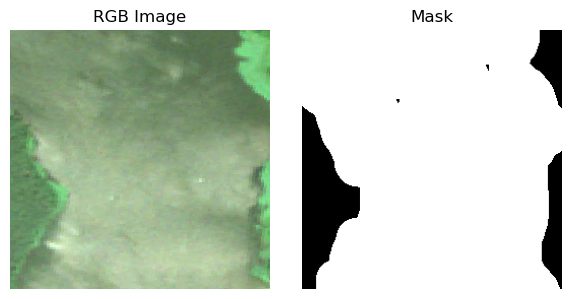

In [ ]:
image_path = "./Data/data_Q3_2023_raw/Modify/10e83f12a06a117695a88c69d4293942/rgb_nir_00_04.tif"
mask_path = "./Data/data_Q3_2023_raw/Modify/10e83f12a06a117695a88c69d4293942/mask_00_04.tif" 

with rasterio.open(image_path) as img_src:
    rgb = img_src.read([1, 2, 3])  # RGB bands

rgb = rgb.astype("float32")
rgb /= rgb.max()

with rasterio.open(mask_path) as mask_src:
    mask = mask_src.read(1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))

ax1.imshow(rgb.transpose(1, 2, 0))
ax1.set_title("RGB Image")
ax1.axis("off")

ax2.imshow(mask, cmap="gray")
ax2.set_title("Mask")
ax2.axis("off")

plt.tight_layout()
plt.show()

56204360dc6b8d005e6063b042510e25
Reconstructing grid of size 8 rows x 8 columns


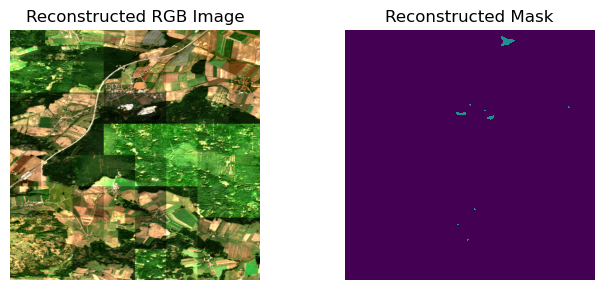

90776d422f5ee5f54be9c53485dec9c9
Reconstructing grid of size 8 rows x 8 columns


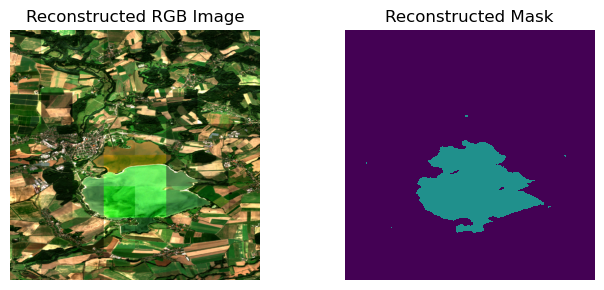

8a8c7c73241951e1dc087a3de8e4f263
Reconstructing grid of size 8 rows x 8 columns


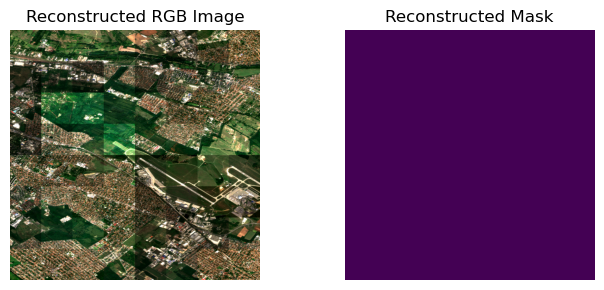

1b7902f98c70611a9f78ca7a787d1608
Reconstructing grid of size 8 rows x 8 columns


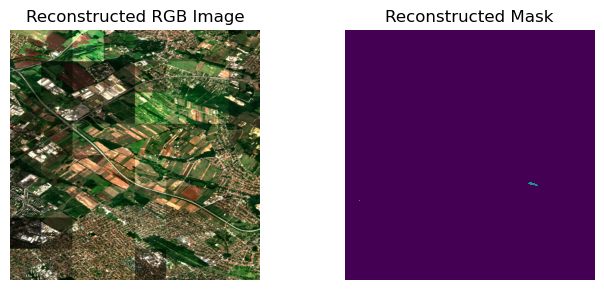

6dbe4543806b7d91d104a7ed379e3c3e
Reconstructing grid of size 8 rows x 8 columns


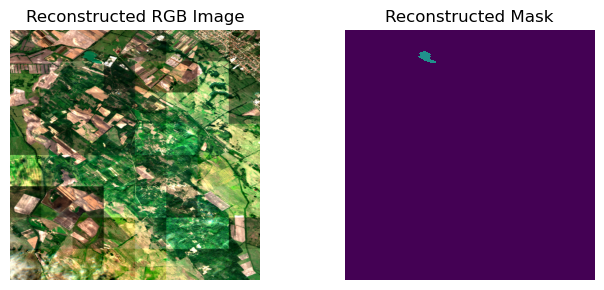

ff76c7702b0fcc844479e4b1e42239f3
Reconstructing grid of size 8 rows x 8 columns


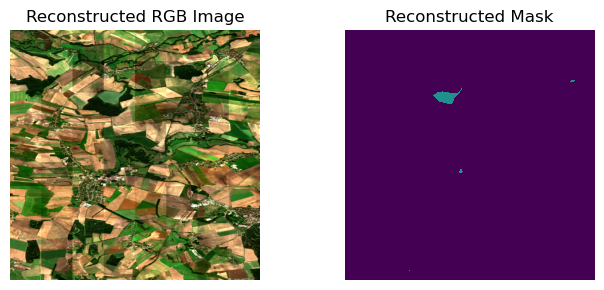

f99431d28a6f66c0ac73dab4e7763a0b
Reconstructing grid of size 8 rows x 8 columns


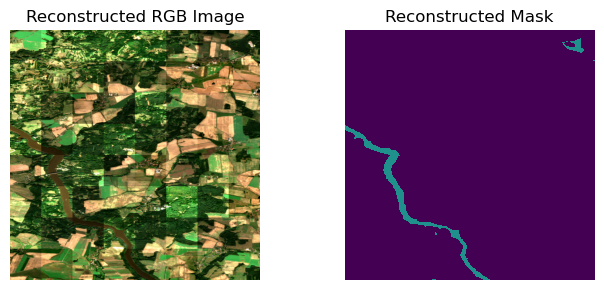

1ba64a41fafa105e6e614fa00d29b758
Reconstructing grid of size 8 rows x 8 columns


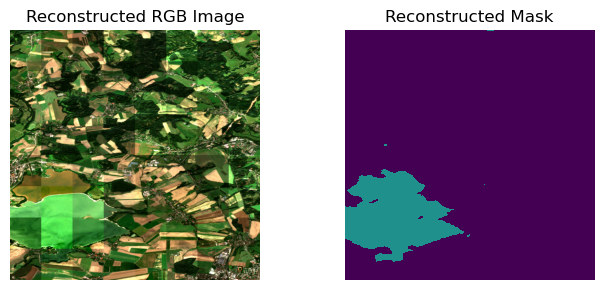

3d7b872ae3af4e62f6a209d393070672
Reconstructing grid of size 8 rows x 8 columns


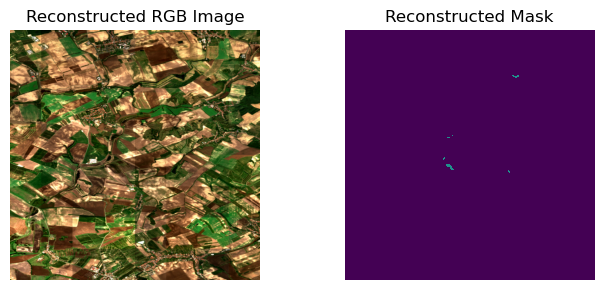

c640e8cf99a82ae30f67cb8f5eb9cb4c
Reconstructing grid of size 8 rows x 8 columns


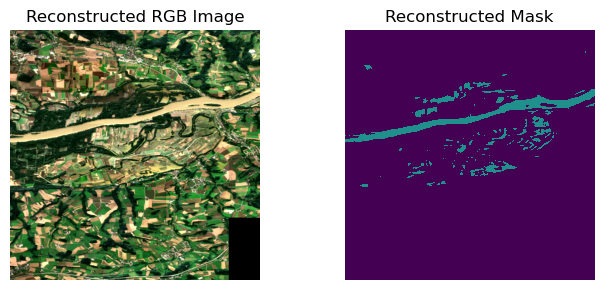

1c50492dcd11cb53748eb73fbf876c8a
Reconstructing grid of size 8 rows x 8 columns


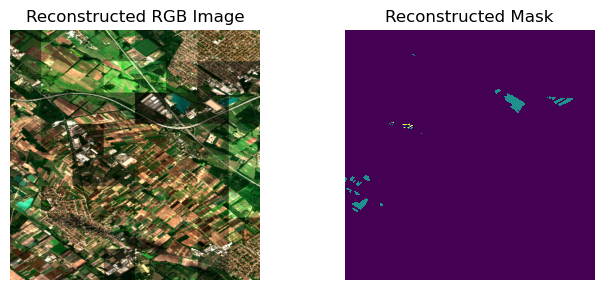

65348760464f2b4afe08d3bc39abb840
Reconstructing grid of size 8 rows x 8 columns


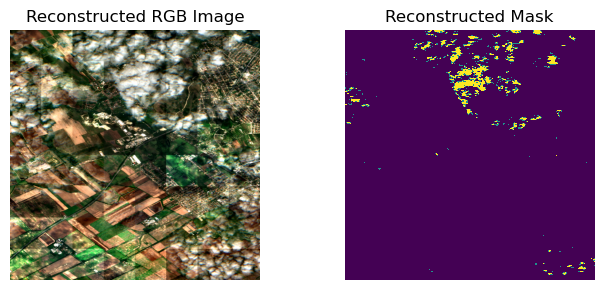

In [12]:
# take a look at the extracted data
masks_creation = load_module("masks_creation", "scripts/data_preparation/masks_creation.py")

visualize_tiled_image_and_mask = masks_creation.visualize_tiled_image_and_mask

import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

data_path = r"./Data_Boris_full/data_BorisFlood2024_raw/OK/"
files = os.listdir(data_path)
files = files

for file in files:
    print(file)
    imgpath = os.path.join(data_path, file)
    visualize_tiled_image_and_mask(imgpath)

b98057d3d8d60556eebb6c16b234e250
Reconstructing grid of size 8 rows x 8 columns


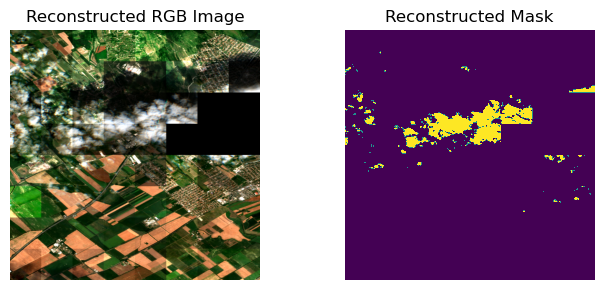

785a3939521df194f8ae48a236598db3
Reconstructing grid of size 8 rows x 8 columns


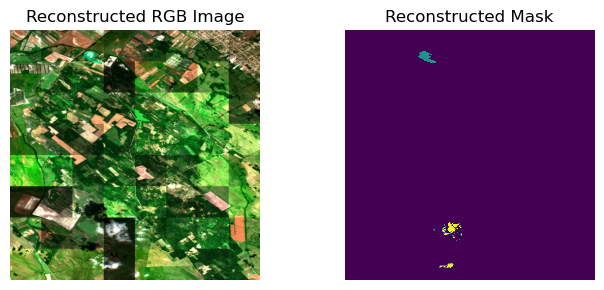

0dad7f24420af89129f93cefb81973c3
Reconstructing grid of size 8 rows x 8 columns


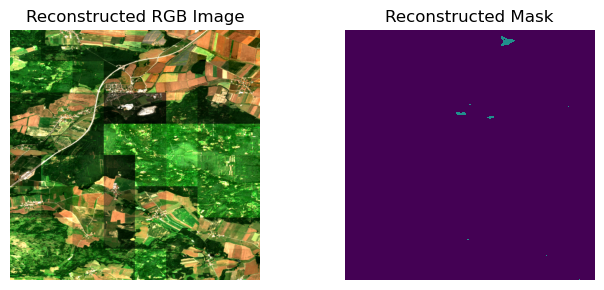

3f7b34ec6afb9431d2cf40dcdd99a00d
Reconstructing grid of size 8 rows x 8 columns


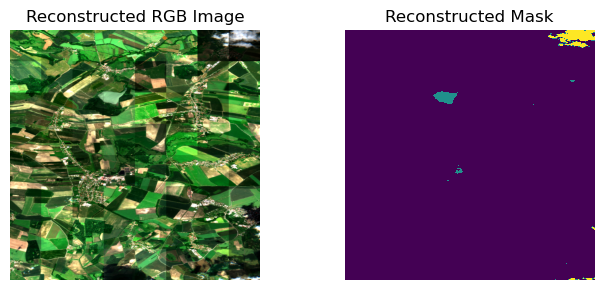

0a2247da5b0a4b01d4c94fff401f981a
Reconstructing grid of size 8 rows x 8 columns


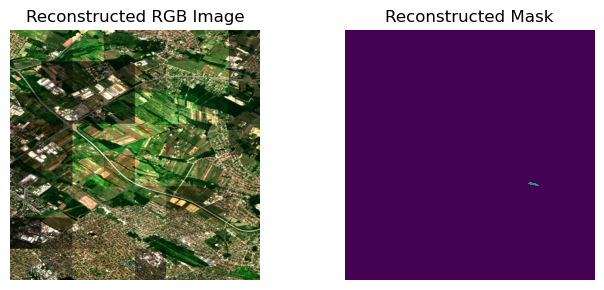

73bafa53ce5c514683c0297be12a4369
Reconstructing grid of size 8 rows x 8 columns


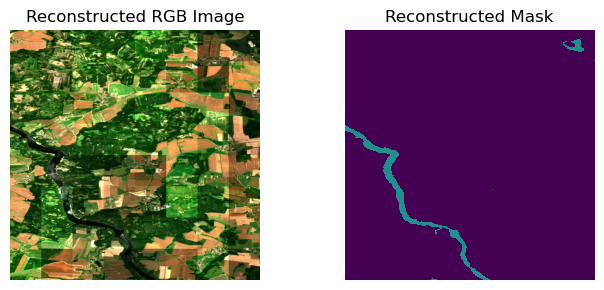

2a8c2ccc99f36e6320923d36b2afc5cf
Reconstructing grid of size 8 rows x 8 columns


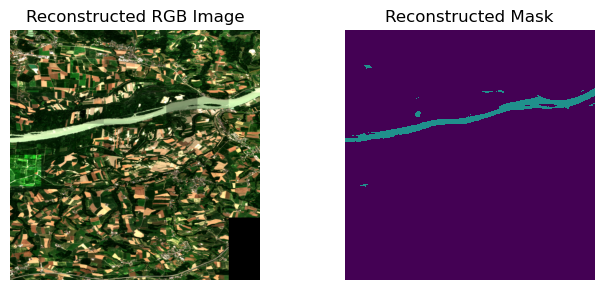

aeebf97111df9998d28ac99ce5b929d0
Reconstructing grid of size 8 rows x 8 columns


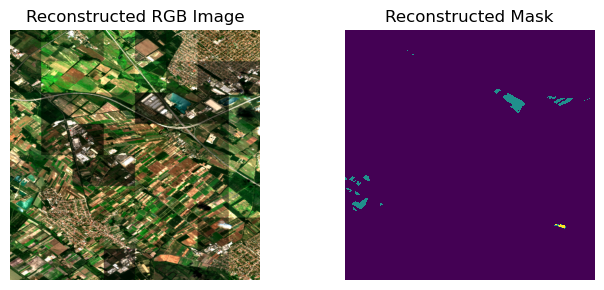

40b0be848db4415613b7f31694a82666
Reconstructing grid of size 8 rows x 8 columns


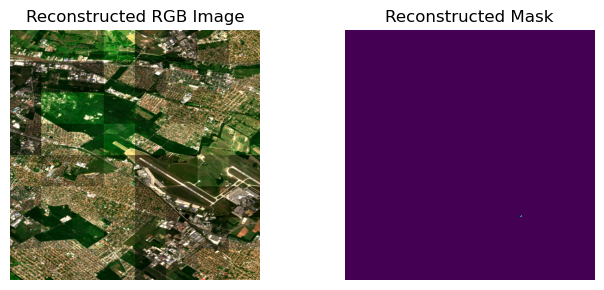

079d91f55d807e3c8f706b16d086446d
Reconstructing grid of size 8 rows x 8 columns


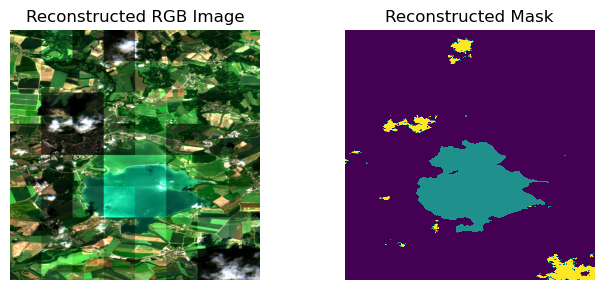

a67dc6fce5c2be8d2e23896ac1373e78
Reconstructing grid of size 8 rows x 8 columns


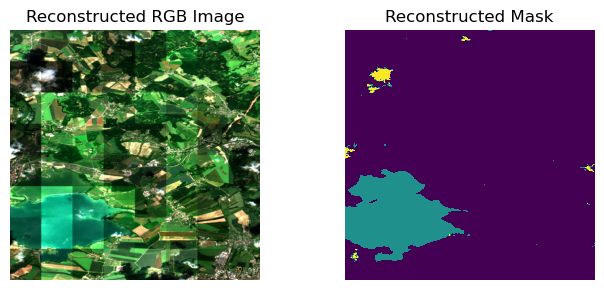

8356764794012020337315c83f29225d
Reconstructing grid of size 8 rows x 8 columns


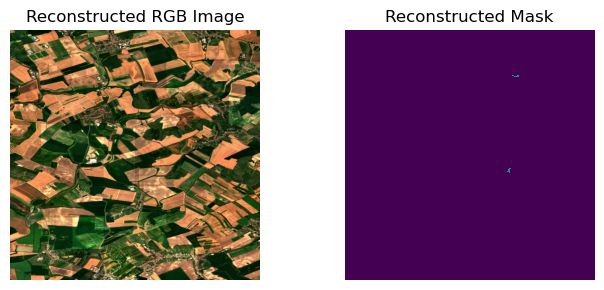

In [13]:
# take a look at the extracted data
masks_creation = load_module("masks_creation", "scripts/data_preparation/masks_creation.py")

visualize_tiled_image_and_mask = masks_creation.visualize_tiled_image_and_mask

import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

data_path = r"./Data_Boris_full/before_data_BorisFlood2024_raw/OK/"
files = os.listdir(data_path)
files = files

for file in files:
    print(file)
    imgpath = os.path.join(data_path, file)
    visualize_tiled_image_and_mask(imgpath)

### Landsat

In [12]:

preprocessing = load_module("preprocessing", "scripts/data_model/preprocessing.py")

collect_patch_paths_and_save = preprocessing.collect_patch_paths_and_save

collect_patch_paths_and_save(
    data_dir="./Data_Landsat",
    save_path="./Data_Landsat/Split/tile_patch_pairs.json"
)

Missing: ./Data_Landsat/Modify
Saved 768 image-mask patch pairs to ./Data_Landsat/Split/tile_patch_pairs.json
Skipped 0 image files due to missing masks.


### Boris

In [11]:

preprocessing = load_module("preprocessing", "scripts/data_model/preprocessing.py")

collect_patch_paths_and_save = preprocessing.collect_patch_paths_and_save

collect_patch_paths_and_save(
    data_dir="./Data_Boris",
    save_path="./Data_Boris/Split/tile_patch_pairs.json"
)

Saved 1446 image-mask patch pairs to ./Data_Boris/Split/tile_patch_pairs.json
Skipped 0 image files due to missing masks.
